In [1]:
import os
os.chdir("..")



In [2]:
from skin_lesion_cad.utils.data_utils import get_class
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import time
import warnings
from pathlib import Path
mpl.rcParams['figure.dpi'] = 200


In [3]:
feature_dir = "data/processed/features"
CHALLENGE = "chall1"


In [4]:

def read_feats(color="raw"):
    save_path = Path("data/processed/features")
    
    glcm_whole_image_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_glcm_original_image.feather"))
    glcm_whole_image_df_train["image"] = glcm_whole_image_df_train["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])
    
    
    lbp_whole_image_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_lbp_original_image.feather"))
    lbp_whole_image_df_train["image"] = lbp_whole_image_df_train["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])
    
    shape_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_shape.feather"))
    shape_df_train["image"] = shape_df_train["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])
    
    color_df_raw_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_raw.feather"))
    color_df_raw_train["image"] = color_df_raw_train["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])
    
    color_df_ms_train = pd.read_feather(
    save_path/Path(f"{CHALLENGE}_train_color_meanshift.feather"))
    color_df_ms_train["image"] = color_df_ms_train["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    
    
    
    glcm_whole_image_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_glcm_original_image.feather"))
    glcm_whole_image_df_val["image"] = glcm_whole_image_df_val["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])
    
    
    lbp_whole_image_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_lbp_original_image.feather"))
    lbp_whole_image_df_val["image"] = lbp_whole_image_df_val["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])
    
    shape_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_shape.feather"))
    shape_df_val["image"] = shape_df_val["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    
    color_df_raw_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_raw.feather"))
    color_df_raw_val["image"] = color_df_raw_val["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    color_df_ms_val = pd.read_feather(
    save_path/Path(f"{CHALLENGE}_val_color_meanshift.feather"))
    color_df_ms_val["image"] = color_df_ms_val["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    
    
    glcm_whole_image_df_test = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_test_glcm_original_image.feather"))
    glcm_whole_image_df_test["image"] = glcm_whole_image_df_test["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])
    
    
    lbp_whole_image_df_test = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_test_lbp_original_image.feather"))
    lbp_whole_image_df_test["image"] = lbp_whole_image_df_test["image"].apply(
        lambda x: x.split("/")[-1].split(".")[0])

    shape_df_test = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_test_shape.feather"))
    shape_df_test["image"] = shape_df_test["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    
    color_df_raw_test = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_test_color_raw.feather"))
    color_df_raw_test["image"] = color_df_raw_test["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    color_df_ms_test = pd.read_feather(
    save_path/Path(f"{CHALLENGE}_test_color_meanshift.feather"))
    color_df_ms_test["image"] = color_df_ms_test["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

    
    if color=="raw":
        dfs = [  # glcm_df_train, lbp_df_train,
            color_df_raw_train,
            glcm_whole_image_df_train, lbp_whole_image_df_train, shape_df_train]
        all_feat_raw_train = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)

        dfs = [  # glcm_df_val, lbp_df_val,
            color_df_raw_val,
            glcm_whole_image_df_val, lbp_whole_image_df_val, shape_df_val]
        all_feat_raw_val = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)

        dfs = [  # glcm_df_val, lbp_df_val,
            color_df_raw_test,
            glcm_whole_image_df_test, lbp_whole_image_df_test, shape_df_test]
        all_feat_raw_test = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)
        return all_feat_raw_train, all_feat_raw_val, all_feat_raw_test

    elif color=="meanshift":
        dfs = [  # glcm_df_train, lbp_df_train,
            color_df_ms_train,
            glcm_whole_image_df_train, lbp_whole_image_df_train, shape_df_train]
        all_feat_raw_train = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)

        dfs = [  # glcm_df_val, lbp_df_val,
            color_df_ms_val,
            glcm_whole_image_df_val, lbp_whole_image_df_val, shape_df_val]
        all_feat_raw_val = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)

        dfs = [  # glcm_df_val, lbp_df_val,
            color_df_ms_test,
            glcm_whole_image_df_test, lbp_whole_image_df_test, shape_df_test]
        all_feat_raw_test = ft.reduce(
            lambda left, right: pd.merge(left, right, on='image'), dfs)
        return all_feat_raw_train, all_feat_raw_val, all_feat_raw_test



In [5]:
save_path = Path("data/processed/features")

df = pd.read_feather(
    save_path/Path(f"{CHALLENGE}_test_shape.feather"))

df["image"].apply(lambda x: x.split("/")[-1].split(".")[0].split("_")[0])

0       xxx03908
1       xxx05677
2       xxx02725
3       xxx02891
4       xxx01938
          ...   
6335    xxx01129
6336    xxx02360
6337    xxx02080
6338    xxx03119
6339    xxx00350
Name: image, Length: 6340, dtype: object

In [6]:
pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_shape.feather"))


,cont_num,mean_cont_area,std_cont_area,area,perim,aspect_ratio,extent,solidity,equi_diameter,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,image
0,2,32762.250000,32419.250000,65181.5,1519.006262,0.962319,67733.787651,0.828122,288.082737,0.191141,0.003924,0.001843,0.000073,2.241994e-08,1.105300e-06,1.450207e-08,data/processed/chall1/train/others/mel00057_in...
1,1,180355.000000,0.000000,180355.0,2692.934316,1.214552,148495.053763,0.780629,479.202586,0.249474,0.027451,0.000219,0.000042,-4.000273e-09,-6.840667e-06,2.243218e-10,data/processed/chall1/train/others/mel02387_in...
2,11,6979.454545,14034.853982,50199.5,1008.531086,1.169960,42907.005068,0.917095,252.816116,0.166652,0.001338,0.000077,0.000001,2.112053e-12,-8.564669e-09,-8.580412e-12,data/processed/chall1/train/others/bcc01321_in...
3,2,44293.250000,34101.750000,78395.0,2020.920039,3.066079,25568.484195,0.666587,315.936092,0.383318,0.102147,0.007003,0.000948,-5.217502e-07,-1.611853e-04,-2.385617e-06,data/processed/chall1/train/others/mel02067_in...
4,1,29754.000000,0.000000,29754.0,1202.170693,1.011952,29402.574803,0.701696,194.638047,0.231914,0.011872,0.000691,0.000078,-1.615631e-08,-8.292720e-06,-8.010601e-09,data/processed/chall1/train/others/bkl01342_in...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15190,1,10425.500000,0.000000,10425.5,509.345233,1.251969,8327.286164,0.869553,115.213536,0.214025,0.016651,0.000156,0.000047,3.732509e-09,6.008428e-06,-1.355210e-09,data/processed/chall1/train/nevus/nev05302_inp...
15191,2,47332.750000,38080.750000,85413.5,3291.093697,1.204444,70915.267528,0.394839,329.775448,0.624787,0.013851,0.003617,0.013530,8.293315e-05,1.211259e-03,4.560103e-05,data/processed/chall1/train/nevus/nev00180_inp...
15192,2,215026.000000,210950.000000,425976.0,6173.643236,1.256442,339033.632812,0.592666,736.457391,0.249811,0.002031,0.002818,0.000314,-1.168486e-07,-1.305829e-05,2.718935e-07,data/processed/chall1/train/nevus/nev00260_inp...
15193,1,73543.500000,0.000000,73543.5,1377.467158,1.205298,61016.859890,0.902568,306.004073,0.177938,0.004675,0.000264,0.000022,1.671387e-09,1.380900e-06,-2.269055e-10,data/processed/chall1/train/nevus/nev03029_inp...


In [7]:
all_feat_train, all_feat_val, all_feat_test = read_feats()


In [8]:
all_feat_train.shape, all_feat_val.shape, all_feat_test.shape


((15195, 359), (3796, 359), (6340, 359))

In [22]:
X_train = all_feat_train.drop(columns='image')
y_train = all_feat_train['image'].apply(get_class, chall=CHALLENGE)
X_val = all_feat_val.drop(columns='image')
y_val = all_feat_val['image'].apply(get_class, chall=CHALLENGE)
X_test = all_feat_test.drop(columns='image')
X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0

X_val[np.isnan(X_val)] = 0
X_val[np.isinf(X_val)] = 0


In [10]:
# X_Train = pd.concat(X_train,X_val)
# y_Train = pd.concat(y_train,y_val)

In [11]:
all_feat_train['image']

0        mel00057
1        mel02387
2        bcc01321
3        mel02067
4        bkl01342
           ...   
15190    nev05302
15191    nev00180
15192    nev00260
15193    nev03029
15194    nev07332
Name: image, Length: 15195, dtype: object

In [10]:
xgb_params = {'base_score': 0.5,
              'booster': 'gbtree',
              'callbacks': None,
              'colsample_bylevel': 1,
              'colsample_bynode': 1,
              'colsample_bytree': 1,
              'early_stopping_rounds': None,
              'enable_categorical': False,
              'eval_metric': 'auc',
              'gamma': 0.4,
              'gpu_id': -1,
              'grow_policy': 'lossguide',
              'importance_type': None,
              'interaction_constraints': '',
              'learning_rate': 0.15,
              'max_bin': 256,
              'max_cat_to_onehot': 4,
              'max_delta_step': 0,
              'max_depth': 10,
              'max_leaves': 0,
              'min_child_weight': 1,
              'monotone_constraints': '()',
              'n_estimators': 100,
              'n_jobs': 0,
              'num_parallel_tree': 1,
              'objective': 'binary:logistic',
              'predictor': 'auto',
              'random_state': 0,
              'reg_alpha': 1.6,
              'reg_lambda': 3.2,
              'sampling_method': 'uniform',
              'scale_pos_weight': 1,
              'subsample': 1,
              'tree_method': 'hist',
              'use_label_encoder': False,
              'validate_parameters': 1,
              'verbosity': None}


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0

X_val[np.isnan(X_val)] = 0
X_val[np.isinf(X_val)] = 0

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

xgb_best = xgb.XGBClassifier(**xgb_params)
xgb_best.fit(X_train_pca, y_train.values.ravel())
#predictions - inputs to confusion matrix
train_predictions = xgb_best.predict(X_train_pca)
test_predictions = xgb_best.predict(X_val_pca)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_val, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_val, test_predictions)
print(accs_train)
print(accs_test)
print(cfm_test)


1.0
0.8327186512118019
[[1597  334]
 [ 301 1564]]


In [60]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score


pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

svc = SVC(kernel='rbf', probability=True,
          class_weight='balanced', C=10, gamma=0.0001)
svc.fit(X_train_pca, y_train.values.ravel())

y_pred = svc.predict(X_val_pca)
print('Confusion Matrix\n', confusion_matrix(y_val, y_pred))
print('\nAccuracy: ', accuracy_score(y_val, y_pred))


Confusion Matrix
 [[1565  366]
 [ 358 1507]]

Accuracy:  0.80927291886196


In [15]:
train_predictions = svc.predict(X_train_pca)
test_predictions = svc.predict(X_val_pca)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_val, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_val, test_predictions)
print(accs_train)
print(accs_test)
print(cfm_test)


0.9068114511352419
0.8445732349841939
[[1630  301]
 [ 289 1576]]


In [48]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
clf1 = SVC(kernel='rbf', probability=True,
                 class_weight='balanced', C=10, gamma=0.0001)
clf2 = xgb.XGBClassifier(**xgb_params)
eclf = VotingClassifier(
    estimators=[('svm', clf1), ('xgb', clf2)], voting='soft')


In [17]:
eclf.fit(X_train_pca,y_train)

NameError: name 'X_train_pca' is not defined

In [18]:
train_predictions = eclf.predict(X_train_pca)
test_predictions = eclf.predict(X_val_pca)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_val, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_val, test_predictions)
print(accs_train)
print(accs_test)
print(cfm_test)


0.9852583086541625
0.8477344573234984
[[1623  308]
 [ 270 1595]]


In [51]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer, cohen_kappa_score, balanced_accuracy_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode




In [53]:
classifiers = [(SVC(kernel='rbf', C=1, probability=True, class_weight='balanced'), 'pca', 'svc_pca'),
(SVC(kernel='rbf', C=100, probability=True, gamma=0.001,class_weight='balanced'), 'pca', 'svc_pca_100'),
               (RandomForestClassifier(bootstrap=False, max_depth=10,
                class_weight='balanced'), 'pca', 'rf_pca'),
               # (SVC(C=10, class_weight='balanced', gamma=0.1,
               #  probability=True), 'pca', 'svc_pca'),
               (XGBClassifier(**xgb_params), 'pca', 'xgb_pca')
        ]


TOP_FEATURES = all_feat_train.drop(columns='image').columns

class EnsemblingClssfifier:
    def __init__(self, class_data:list, ensembling=None) -> None:
        self.class_data = class_data
        self.model_names = [x[2] for x in class_data]
        self.smote = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority')
        self.tf_fs_set = TOP_FEATURES
        self.transformer = StandardScaler()
        self.pca = PCA(n_components=150)
        self.ensembling = ensembling
        
    def fit(self, X, y, columns_X):
        """X - raw 442 shape array with features
        columngs_X - list of columns names used to make X
        only once pca per class  data"""
        # normalize data
        X = self.transformer.fit_transform(X)
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                model.fit(X, y)
            elif dataset == 'smote':
                X_smote, y_smote = self.smote.fit_resample(X, y)
                model.fit(X_smote, y_smote)
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                model.fit(X_rf, y)           
            elif dataset == 'pca':
                X_pca = self.pca.fit_transform(X)
                model.fit(X_pca, y)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling:
            self.meta_model = LogisticRegression()
            predictions, predicitons_proba = self.predict(X, columns_X, False)
            predictions = {k:v for k,v in predictions.items() if k in self.model_names}
            predicitons_proba = {k:v for k,v in predicitons_proba.items() if k in self.model_names}
            self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
        
    def predict(self, X, columns_X, with_meta=True):
        X = self.transformer.fit_transform(X)
        
        predictions = dict()
        predicitons_proba = dict()
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)

            elif dataset == 'smote':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)
            
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                predictions[name] = model.predict(X_rf)
                predicitons_proba[name] = model.predict_proba(X_rf)
            elif dataset == 'pca':
                X_pca = self.pca.transform(X)
                predictions[name] = model.predict(X_pca)
                predicitons_proba[name] = model.predict_proba(X_pca)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling and with_meta:
            predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
            predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))
            
        if 'hard_voting' in self.ensembling:
            predictions['hard_voting'] = mode(np.stack([v for k,v in predictions.items() if k in self.model_names]), axis=0)[0][0]
            predicitons_proba['hard_voting'] = None
            
        if 'soft_voting' in self.ensembling:
            predicitons_proba['soft_voting'] = np.asarray([v for k, v in predicitons_proba.items() if k in self.model_names]).mean(axis=0)
            predictions['soft_voting'] = predicitons_proba['soft_voting'].argmax(axis=1)
            
        return predictions, predicitons_proba
    
    def evaluate(self, X, y, columns_X, plot=True):
        predictions, predicitons_proba = self.predict(X, columns_X)
        kappa_scores = {name: cohen_kappa_score(y, pred) for name, pred in predictions.items()}
        balacc_scores = {name: accuracy_score(y, pred) for name, pred in predictions.items()}
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(18, 6))

            # plot bar plot of the dict
            sns.barplot(y=list(kappa_scores.values()), x=list(kappa_scores.keys()), ax=axs[0])
            axs[0].set_title('Kappa scores')
            axs[0].bar_label(axs[0].containers[0])

            sns.barplot(y=list(balacc_scores.values()), x=list(balacc_scores.keys()), ax=axs[1])
            axs[1].set_title('Accuracy scores')
            axs[1].bar_label(axs[1].containers[0])


            plt.show()
        return kappa_scores, balacc_scores

In [43]:
ens = EnsemblingClssfifier(classifiers, ['soft_voting', 'stacking', 'hard_voting'])

ens.fit(X_train, y_train, all_feat_train.drop(columns='image').columns)


/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  predictions['hard_voting'] = mode(np.stack([v for k,v in predictions.items() if k in self.model_names]), axis=0)[0][0]
/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:50: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.meta_model.fit(np.hstack(predicitons_proba.values()), y)


/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:79: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:80: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))
/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the

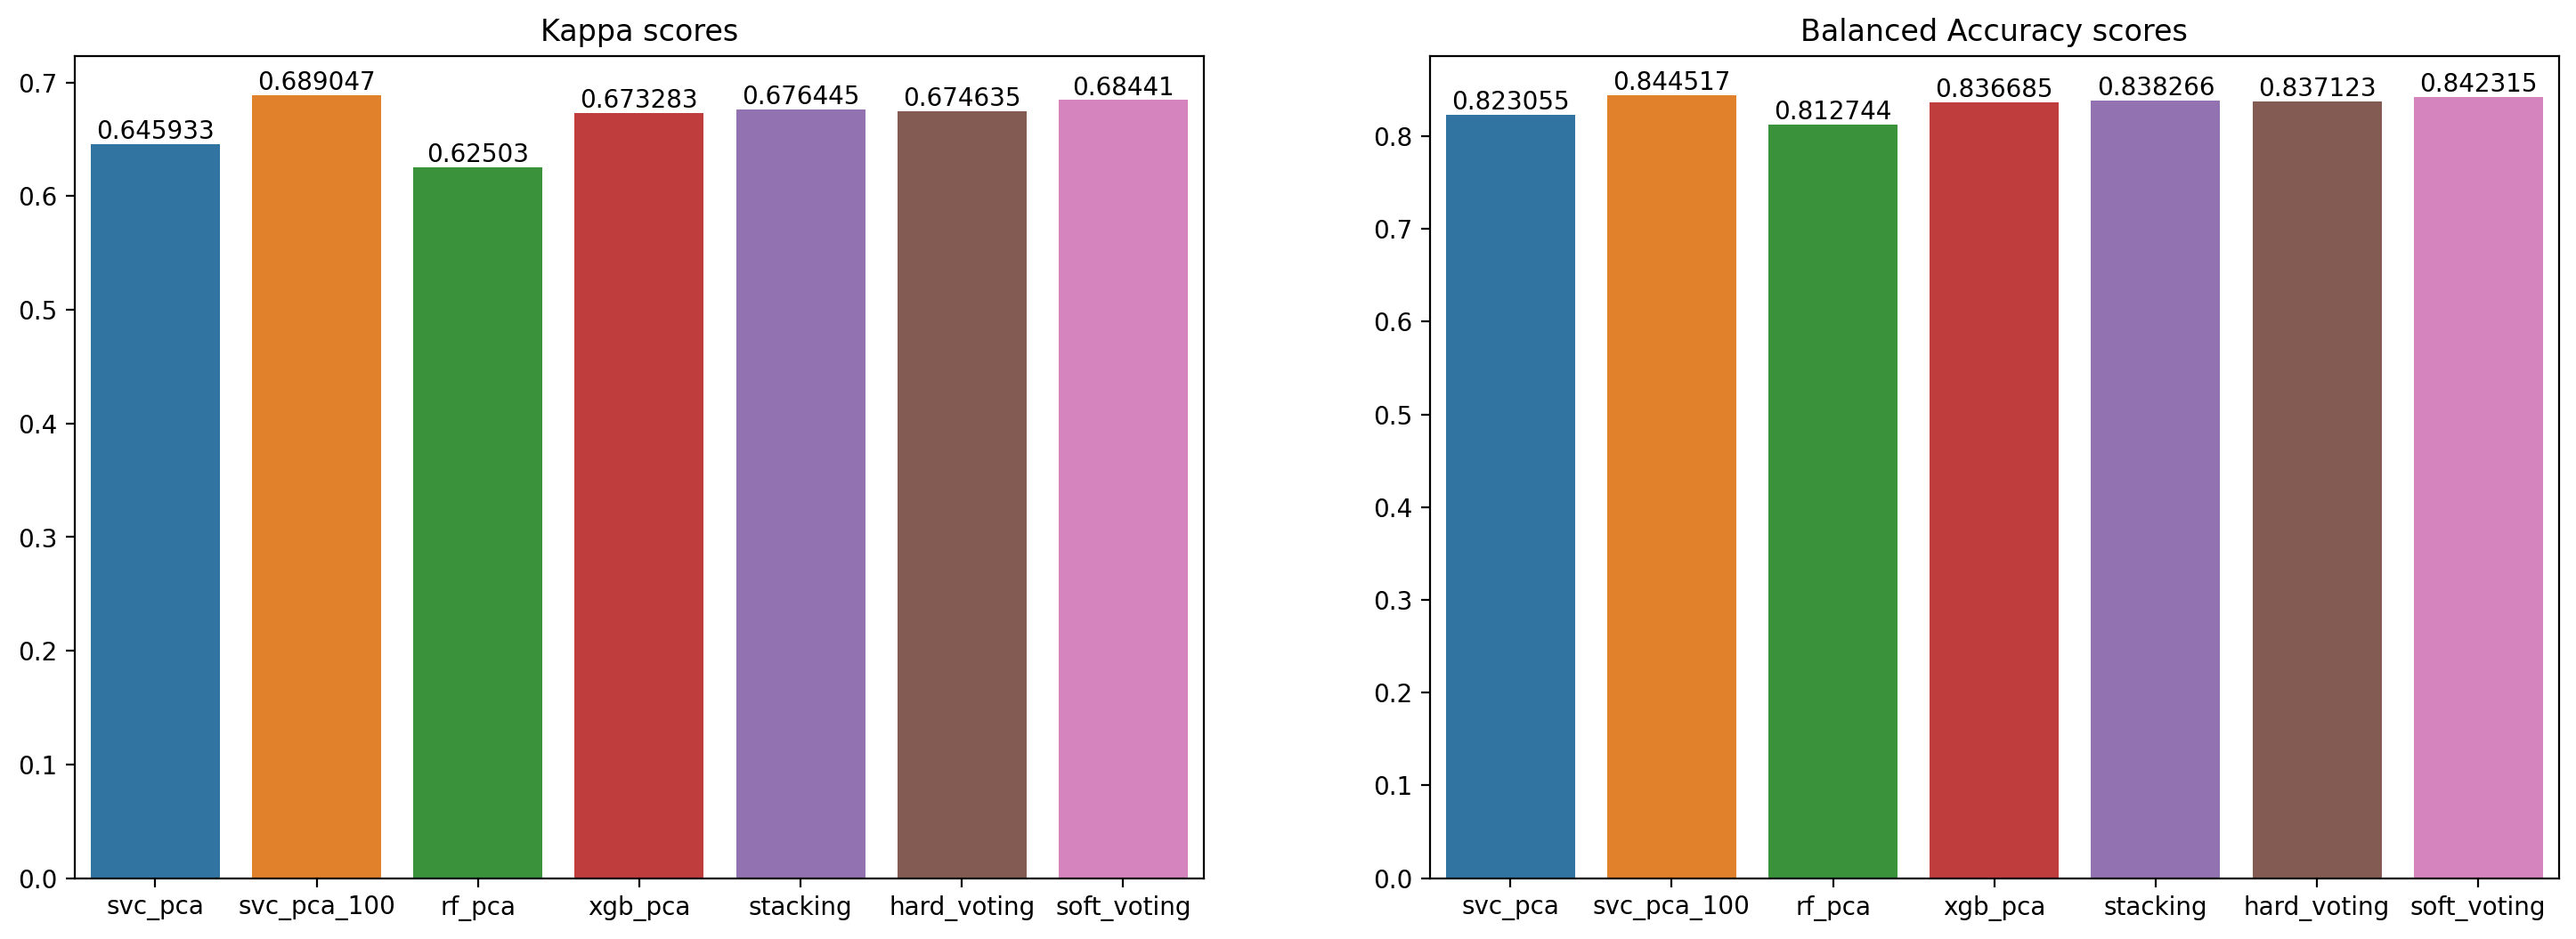

In [54]:
kappa_scores, balacc_scores = ens.evaluate(X_val.values, y_val.values, all_feat_val.drop(columns='image').columns)



/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:79: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:80: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))
/var/folders/bn/7y_4lmg577bc50d90kdc9v040000gn/T/ipykernel_45257/3562652856.py:83: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the

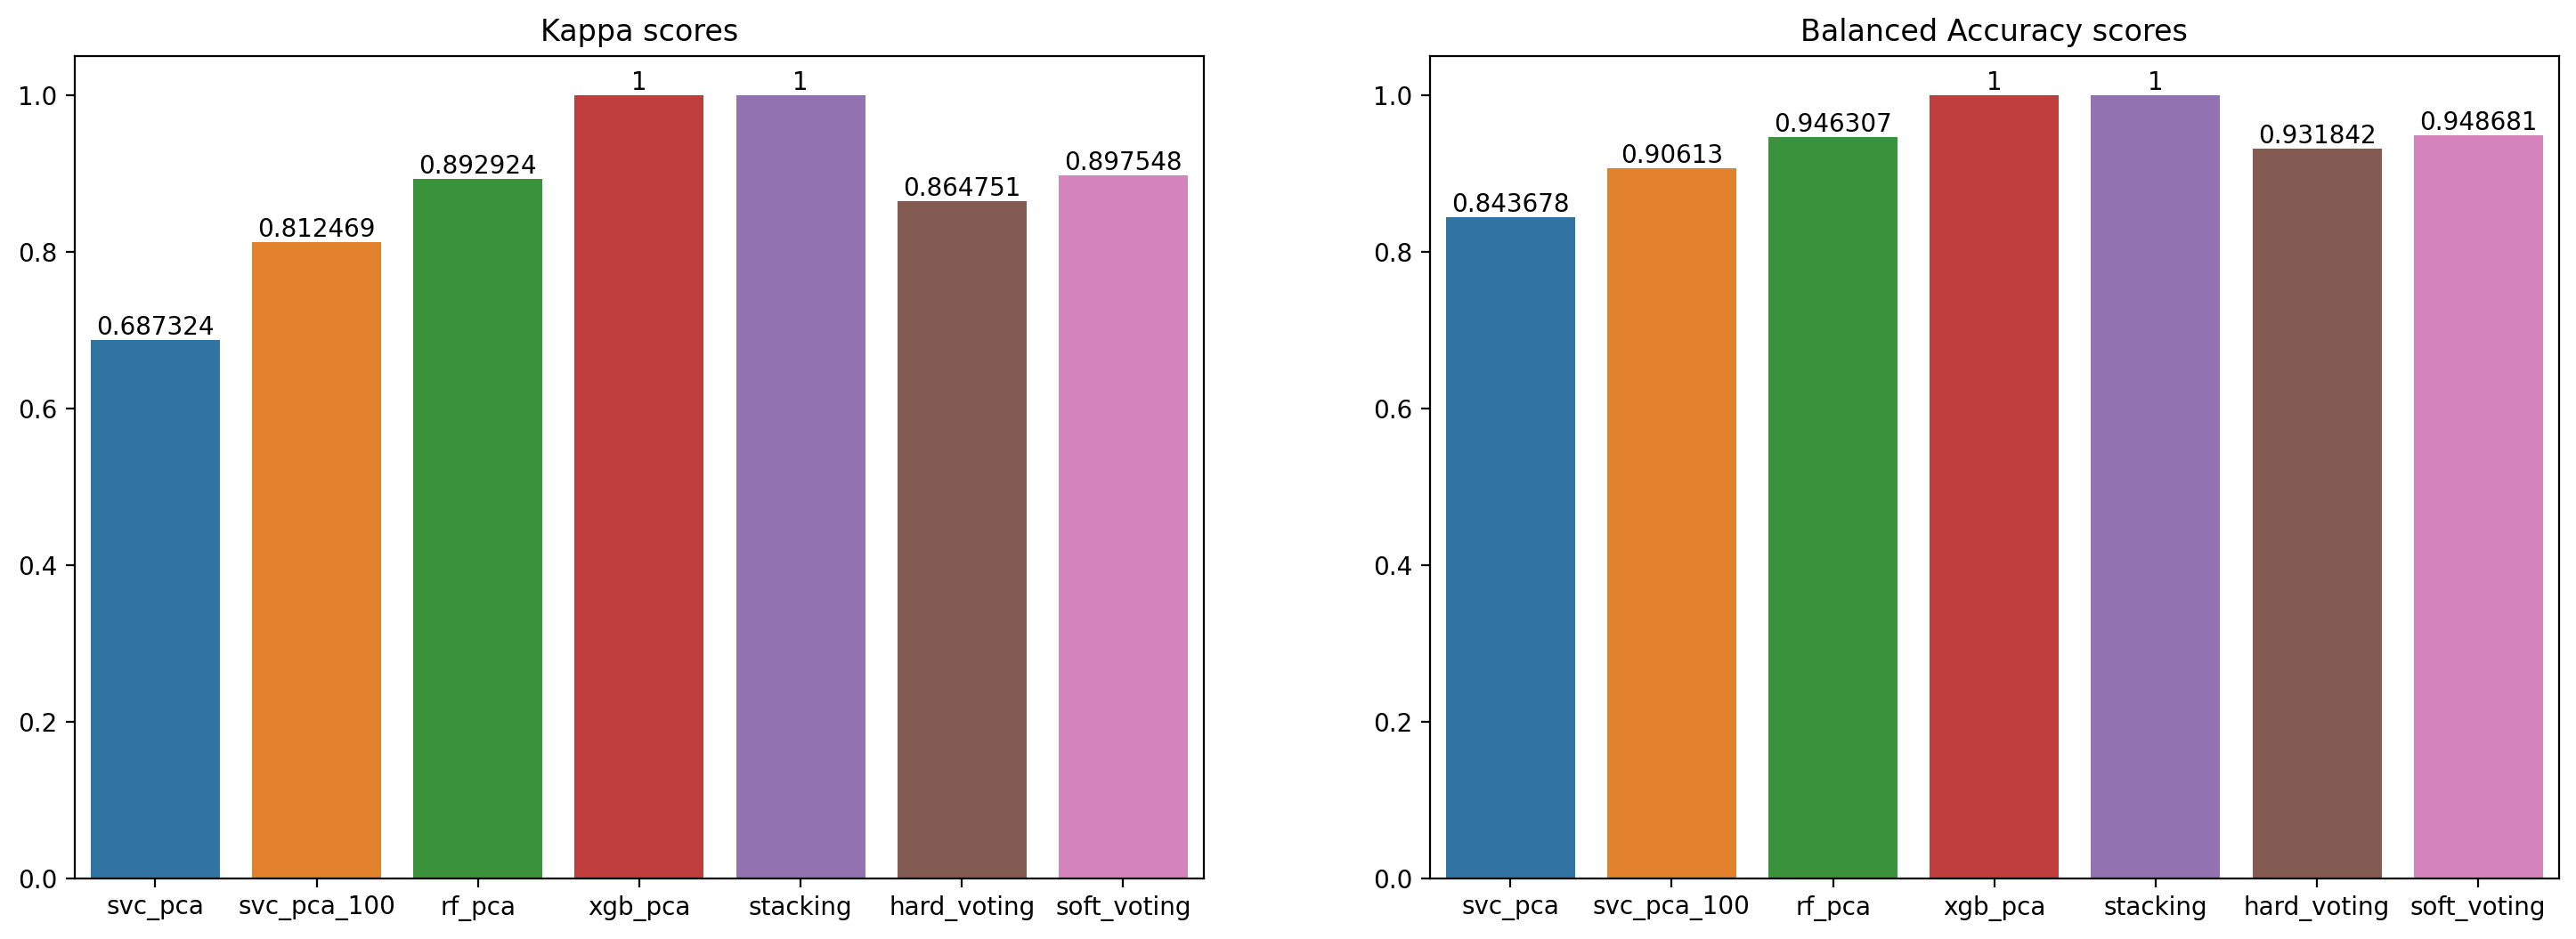

In [55]:
kappa_scores, balacc_scores = ens.evaluate(X_train.values, y_train.values, all_feat_val.drop(columns='image').columns)


In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = RandomizedSearchCV(SVC(), param_grid, refit=True, verbose=3)


# fitting the model for grid search
grid.fit(X_train, y_train)


# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_val)

# print classification report


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.514 total time=  42.6s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.513 total time=  36.4s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.514 total time=  34.5s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.513 total time=  33.4s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.513 total time=  35.2s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.519 total time= 1.3min
[CV 2/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.516 total time= 1.2min
[CV 3/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.522 total time= 1.3min
[CV 4/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.515 total time= 1.2min
[CV 5/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.517 total time= 1.3min
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.512 total time= 1.1min
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;

NameError: name 'classification_report' is not defined

In [57]:
grid_predictions = grid.predict(X_val)


In [58]:
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.51      0.99      0.68      1931
           1       0.72      0.03      0.06      1865

    accuracy                           0.52      3796
   macro avg       0.61      0.51      0.37      3796
weighted avg       0.61      0.52      0.38      3796



In [47]:
print(grid.best_params_)


{'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}
